In [1]:
# import libraries
from pyopenms import *
import os

In [2]:
# change directory to find file of interest
os.chdir(r'C:\Users\miar\Desktop\data')

In [3]:
#------------------------------------------------------------------------------------------------------------------------------

# ONLY NEED TO RUN THE NEXT THREE BLOCKS ONCE

#-------------------------------------------------------------------------------------------------------------------------------

In [4]:
# load the content of the mzML file into the exp variable of type MSExperiment
#exp = MSExperiment()
#MzMLFile().load("HEK293T_De_Novo_053122_Glu-C_B_correctRTSenzyme_BP.mzML", exp)

# access the raw data and spectra
#spectrum_data = exp.getSpectrum(0).get_peaks()
#spectrum_data

In [5]:
# loop through the spectra to gather MS2 scans
#specM2 = []
#for s in exp.getSpectra():
#    if s.getMSLevel() == 2:
#        specM2.append(s)
        
#print("Number of MS2 scans: " + str(len(specM2)))

#exp.setSpectra(specM2) # keep only MS2

# store the modified data structure on disk
#MzMLFile().store("filtered_MS2.mzML", exp)

In [6]:
# loop through the spectra to gather MS3 scans
#specM3 = []
#for s in exp.getSpectra():
#    if s.getMSLevel() == 3:
#        specM3.append(s)
        
#print("Number of MS3 scans: " + str(len(specM3)))

#exp.setSpectra(specM3) # keep only MS3

# store the modified data structure on disk
#MzMLFile().store("filtered_MS3.mzML", exp)

In [7]:
# parse functions
def parseScanLine(input):
    x = input.split(" For: ")
    [scan_number, mzs] = x[1].split(", ")
    [precursor_mz, fragment_mz] = mzs.split(";")
    trimmed_fragment_mz = fragment_mz.strip() # trim fragment strings to remove \n
    return [scan_number, precursor_mz, trimmed_fragment_mz]

def parseTargetIons(input):
    i = input.split('Target Fragment: ')
    ion = i[1].split(',')[0]
    return ion 

In [8]:
# checking lines of log file and creating dictionary of scan numbers and fragment mzs
try:
  
    # words to search for
    search = ' Submitted Custom Scan For:'
    search_target = 'Target Fragment:'
    
    # dict for scan numbers and corresponding fragments 
    scan2frag = dict()
    target_values = []
    with open('App-2022-05-31_20-49-35.log') as f:
        for line in f:
            if search in line:
                scan_number, precursor_mz, trimmed_fragment_mz = parseScanLine(line)
                scan2frag[scan_number] = [float(precursor_mz), float(trimmed_fragment_mz)]
            elif search_target in line:
                target_ion = parseTargetIons(line)
                target_values.append(target_ion) #to add to final dataframe
            
    # if the input string doesn't exist in the text file
    if len(scan2frag)==0:
        print("\n\"" +search+ "\" is not found in \"" +'App-2022-05-31_20-49-35.log'+ "\"!")

except FileNotFoundError:
    print("The file does not exist!")

In [9]:
# load in MS2 scans
exp1 = MSExperiment()
MzMLFile().load("filtered_MS2.mzML", exp1)

In [10]:
# read in peptide sequence from tsv
import pandas as pd
tsv = pd.read_csv('HEK293T_De_Novo_053122_Glu-C_B_correctRTSenzyme_BP_realtimesearch1.tsv', sep='\t')

# create dictionary with scan # as key and sequence/charge as values
scan2PeptideCharge = dict([(i, [x,y]) for i, x,y, in zip(tsv['Scan Number'], tsv['Peptide'], tsv['Charge State'])])

# removing all NaN sequences (not useful)
scan2PeptideCharge_modified = {k:v for k,v in scan2PeptideCharge.items() if str(v[0]) != 'nan'}

In [11]:
def findFragments(peptide_object, charge):
    # loop through each prefix and suffix (b and y ions, respectively)
    # y and b ions

    b_index = []
    y_index = []
    for ion in range(1, (peptide_object.size())): # start at index of 1, end at peptide length - 1
        y_ion = peptide_object.getSuffix(ion)
        b_ion = peptide_object.getPrefix(ion)

        for z in range(1, charge):
            mz_b = b_ion.getMonoWeight(Residue.ResidueType.BIon, z) / z
            b_index.append(s.findNearest(mz_b, 0.4))

            mz_y = y_ion.getMonoWeight(Residue.ResidueType.YIon, z) / z
            y_index.append(s.findNearest(mz_y, 0.4))

    y_index.reverse() # reverse list (the first b ion corresponds with the last y ion)
    
    # skim list for each corresponding y and b fragments based on charge states
    count = 0
    missing_list = []
    for fragment_index in range(0, len(y_index), charge-1): # check after 'x' mzs (possible charge states)
        
        count = count + 1
        
        check_b = b_index[fragment_index : fragment_index+charge-1]
        check_y = y_index[fragment_index : fragment_index+charge-1]

        if all(item == -1 for item in check_b) and all(item == -1 for item in check_y):
            missing_list.append(str(count))
        
        number_missing = len(missing_list)
        missing_list_mod = ",".join(str(i) for i in missing_list)

    return missing_list_mod, number_missing

In [12]:
table_rows = []
for s in exp1:
    s_number = s.getNativeID().split(' ')[-1]
    _, scan_number = s_number.split('=')
    
    if scan_number in scan2frag and int(scan_number) in scan2PeptideCharge_modified:
        # isolate peptide sequence from dict
        sequence = scan2PeptideCharge_modified[int(scan_number)][0]     
        trimmed_sequence = sequence[2:-2] # remove first two and last two characters 
        
        # isolate charge from dict
        charge = scan2PeptideCharge_modified[int(scan_number)][1]
 
        # create peptide object 
        peptide_object = AASequence.fromString(trimmed_sequence)
        
        # call findFragments function
        missing_list_mod, number_missing = findFragments(peptide_object, charge)
        
        # creating table
        #myTable.add_row([scan_number, trimmed_sequence, peptide_object.size(), missing_list])
        add_row = {'Scan_Number':scan_number, 
                'Sequence':trimmed_sequence,
                'Sequence_Length':peptide_object.size(),
                'Missing_Fragment_Locations':missing_list_mod,
                   'Number_Missing':number_missing}
        table_rows.append(add_row)

In [13]:
# add columns in df for precursor and fragment mzs (used later for MS3 matching)
precursor_mzs = []
for scan in list(scan2frag):
    precursor_mzs.append(scan2frag[scan][0])
    
fragment_mzs = []
for scan in list(scan2frag):
    fragment_mzs.append(scan2frag[scan][1])

In [14]:
# create dataframe to be exported as table later 
df = pd.DataFrame(table_rows)
# add targeted fragment column and precursor mz column
fragment_df = df.assign(Target_Fragment=target_values)

In [15]:
fragment_df[:10]

Scan_Number                                 Sequence  Sequence_Length  \
0        2140                    IFKNGSKRMIATVPLRHSIRD               21   
1        2534        RQVPLASPSSM[15.9949]SAALRGISCYLKE               24   
2        3148          KAQAIIATMGGTTLMASAHSWAKSSSFSCPE               31   
3        3582              KSSM[15.9949]KRKLPFTISPSRNE               18   
4        3716  AVCGAGPPSGLLPLPGPDPGPRGSQGSPTPTRAPASGPE               39   
5        4057                   MASCAEPSEPSAPLPAGVPPLE               22   
6        4068                   KLM[15.9949]QLNLCSNRLE               13   
7        4111                      RFNHFSLTLNTNHGHILVD               19   
8        4149                       RRYCNSHLQVLGFIPKKE               18   
9        4150                       KPATDPVLQVVYKSQGKE               18   

                          Missing_Fragment_Locations  Number_Missing  \
0                                                 13               1   
1                     1,4,5,6,8,10,13,14,16,21,22,23              12   
2  1,2,3,4,6,8,9,11,13,15,18,19,20,21,22,23,24,26...              22   
3                               3,4,6,10,11,13,14,16               8   
4     1,2,3,5,6,8,9,12,14,15,18,24,26,28,32,34,36,38              18   
5                               4,5,7,10,14,15,16,20               8   
6                                                2,6               2   
7                                          1,2,16,17               4   
8                                              1,2,7               3   
9                                        3,5,7,12,15               5   

  Target_Fragment  
0              y6  
1              y5  
2              b4  
3              y3  
4              b4  
5              b2  
6              y4  
7              y4  
8              y4  
9              b6

In [16]:
# export df to tsv 
#fragment_df.to_csv('fragmentInfoTable.tsv', sep=' ', index=False)

In [17]:
# perform table modifications and plot histograms in R...
# ...
# ...

In [16]:
# read in modified table
checktargets_df = pd.read_csv('fragmentInfoTable_altered.tsv', sep="/t", engine='python')

In [17]:
# peek at the first 20 rows for manually checking if subsequent code has expected output
checktargets_df.loc[:20]

"Scan_Number"                           "Sequence"  "Sequence_Length"  \
0            2140              "IFKNGSKRMIATVPLRHSIRD"                 21   
1            2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
2            2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
3            2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
4            2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
5            2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
6            2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
7            2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
8            2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
9            2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
10           2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
11           2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
12           2534  "RQVPLASPSSM[15.9949]SAALRGISCYLKE"                 24   
13           3148    "KAQAIIATMGGTTLMASAHSWAKSSSFSCPE"                 31   
14           3148    "KAQAIIATMGGTTLMASAHSWAKSSSFSCPE"                 31   
15           3148    "KAQAIIATMGGTTLMASAHSWAKSSSFSCPE"                 31   
16           3148    "KAQAIIATMGGTTLMASAHSWAKSSSFSCPE"                 31   
17           3148    "KAQAIIATMGGTTLMASAHSWAKSSSFSCPE"                 31   
18           3148    "KAQAIIATMGGTTLMASAHSWAKSSSFSCPE"                 31   
19           3148    "KAQAIIATMGGTTLMASAHSWAKSSSFSCPE"                 31   
20           3148    "KAQAIIATMGGTTLMASAHSWAKSSSFSCPE"                 31   

    "nTerminusEnd"  "Number_Missing" "Target_Fragment"  "cTerminusEnd"  
0             13.0                 1              "y6"             8.0  
1              1.0                12              "y5"            23.0  
2              4.0                12              "y5"            20.0  
3              5.0                12              "y5"            19.0  
4              6.0                12              "y5"            18.0  
5              8.0                12              "y5"            16.0  
6             10.0                12              "y5"            14.0  
7             13.0                12              "y5"            11.0  
8             14.0                12              "y5"            10.0  
9             16.0                12              "y5"             8.0  
10            21.0                12              "y5"             3.0  
11            22.0                12              "y5"             2.0  
12            23.0                12              "y5"             1.0  
13             1.0                22              "b4"            30.0  
14             2.0                22              "b4"            29.0  
15             3.0                22              "b4"            28.0  
16             4.0                22              "b4"            27.0  
17             6.0                22              "b4"            25.0  
18             8.0                22              "b4"            23.0  
19             9.0                22              "b4"            22.0  
20            11.0                22              "b4"            20.0

In [18]:
# load in MS3 scans
exp2 = MSExperiment()
MzMLFile().load("filtered_MS3.mzML", exp2)

In [19]:
# obtain MS3 scan numbers
# obtain precursor and fragment mzs directly from the MS3 spectrum

ms3scan2MZs = dict()
for s in exp2:
    s_number = s.getNativeID().split(' ')[-1]
    _, scan_number = s_number.split('=')
   
    fragment, precursor = s.getPrecursors()
    precursor_mz = precursor.getMZ()
    fragment_mz = fragment.getMZ()
    
    ms3scan2MZs[int(scan_number)] = [round(float(precursor_mz), 4), round(float(fragment_mz), 4)] # 4 decimal places, similar to log

In [45]:
def matchingMS3s(which_mz_list, type_str): # either fragment or precursor
    
    if type_str == 'Precursor mzs':
        values = []
        for i in list(ms3scan2MZs.values()):
            value = i[0]
            values.append(value)
    elif type_str == 'Fragment mzs':
        values = []
        for i in list(ms3scan2MZs.values()):
            value = i[1]
            values.append(value)
    
    # making sure they are within 100 scans of each other
    too_far = []
    for ms2scan, ms3scan in zip(list(scan2frag), list(ms3scan2MZs)):
        scan_diff = int(ms3scan) - int(ms2scan)
        if scan_diff > 100:
            too_far.append('Scans are not within 100 scans of each other...' + 'MS2 = ' + ms2scan + ' MS3 = ' + ms3scan)
    
    # do they not match off the bat?
    if values != which_mz_list:
        
        # taking into consideration rounding discrepencies between the log and the spectrum
        mismatch = []
        for i in range(0, len(which_mz_list)):
            diff = float(values[i]) - float(which_mz_list[i]) 
            if diff < 0.000101 or (diff < 0 and diff > -0.000101): # because sometimes a number will be 0.0001000002 for example
                pass
            else:
                mismatch.append(i)
                
        # no mismatch after rounding and within 100 scans
        if len(mismatch) == len(too_far) == 0:
            print(type_str + ' match up after taking rounding discrepencies into consideration')
            new_fragment_df = fragment_df.assign(MS3_Scan_Number = list(ms3scan2MZs))
            return new_fragment_df
        elif len(mismatch) != 0:
            print('There is mismatch at the following indicies:') # if this is the case, need to do more work...
            for i in mismatch:
                print(i) 
        elif len(too_far) != 0:
            print(too_far)
       
    # they match perfectly
    elif values == which_mz_list:
        
        # within 100 scans
        if len(too_far) == 0:
            print(type_str + ' match up perfectly!')
            new_fragment_df = fragment_df.assign(MS3_Scan_Number = list(ms3scan2MZs))
            return new_fragment_df
        else:
            print(too_far)

In [46]:
# matching precursor mzs between MS2 (log) and MS3 (spectrum)
new_fragment_df = matchingMS3s(precursor_mzs, 'Precursor mzs')

Precursor mzs match up after taking rounding discrepencies into consideration


In [47]:
# matching fragment mzs between MS2 (log) and MS3 (spectrum)
new_fragment_df = matchingMS3s(fragment_mzs, 'Fragment mzs')

Fragment mzs match up perfectly!


In [ ]:
# after making sure MS2s and MS3s line up, we can continue...

In [ ]:
# MS3 targets the most abundant fragment...let's find what the sequence of that fragment is 

In [48]:
new_fragment_df

Scan_Number                                 Sequence  Sequence_Length  \
0           2140                    IFKNGSKRMIATVPLRHSIRD               21   
1           2534        RQVPLASPSSM[15.9949]SAALRGISCYLKE               24   
2           3148          KAQAIIATMGGTTLMASAHSWAKSSSFSCPE               31   
3           3582              KSSM[15.9949]KRKLPFTISPSRNE               18   
4           3716  AVCGAGPPSGLLPLPGPDPGPRGSQGSPTPTRAPASGPE               39   
...          ...                                      ...              ...   
2722       80065          IAPFLCHPNLWIRYGAVGFITVVARQISTAD               31   
2723       80148               FKMHKKGYNRHNQCLTTSHSKIFQCD               26   
2724       80485                LTLLAFALARGSVAKVMSSLCTITD               25   
2725       80530                 IVNSLQKM[15.9949]QNKGGGD               15   
2726       82545                        RPWNPPTFSPALLVVTE               17   

                             Missing_Fragment_Locations  Number_Missing  \
0                                                    13               1   
1                        1,4,5,6,8,10,13,14,16,21,22,23              12   
2     1,2,3,4,6,8,9,11,13,15,18,19,20,21,22,23,24,26...              22   
3                                  3,4,6,10,11,13,14,16               8   
4        1,2,3,5,6,8,9,12,14,15,18,24,26,28,32,34,36,38              18   
...                                                 ...             ...   
2722                  5,8,12,13,14,16,21,23,27,28,29,30              12   
2723                                                 19               1   
2724                                          2,8,13,24               4   
2725                                               6,11               2   
2726                                             5,9,11               3   

     Target_Fragment  MS3_Scan_Number  
0                 y6             2148  
1                 y5             2543  
2                 b4             3158  
3                 y3             3585  
4                 b4             3727  
...              ...              ...  
2722              y6            80071  
2723              b3            80156  
2724              b6            80493  
2725              b2            80536  
2726              y4            82557  

[2727 rows x 7 columns]

In [55]:
new_fragment_df.drop(columns=['Scan_Number', 'Sequence_Length', 'Missing_Fragment_Locations', 'Number_Missing'], inplace=True)

In [61]:
new_fragment_df[:10]

Sequence Target_Fragment  MS3_Scan_Number
0                    IFKNGSKRMIATVPLRHSIRD              y6             2148
1        RQVPLASPSSM[15.9949]SAALRGISCYLKE              y5             2543
2          KAQAIIATMGGTTLMASAHSWAKSSSFSCPE              b4             3158
3              KSSM[15.9949]KRKLPFTISPSRNE              y3             3585
4  AVCGAGPPSGLLPLPGPDPGPRGSQGSPTPTRAPASGPE              b4             3727
5                   MASCAEPSEPSAPLPAGVPPLE              b2             4064
6                   KLM[15.9949]QLNLCSNRLE              y4             4072
7                      RFNHFSLTLNTNHGHILVD              y4             4114
8                       RRYCNSHLQVLGFIPKKE              y4             4152
9                       KPATDPVLQVVYKSQGKE              b6             4153

In [76]:
# find the sequences of the most abundant fragments 
fragment_seqs = []
for i in new_fragment_df.index:
    
    if new_fragment_df['Target_Fragment'][i].startswith('y'):
        y_num = new_fragment_df['Target_Fragment'][i][-1]
        new_seq = new_fragment_df['Sequence'][i][-int(y_num):]
        fragment_seqs.append(new_seq)
    
    elif new_fragment_df['Target_Fragment'][i].startswith('b'):
        b_num = new_fragment_df['Target_Fragment'][i][-1]
        new_seq = new_fragment_df['Sequence'][i][:int(b_num)]
        fragment_seqs.append(new_seq)

In [77]:
fragment_seqs

['RHSIRD',
 'CYLKE',
 'KAQA',
 'RNE',
 'AVCG',
 'MA',
 'NRLE',
 'ILVD',
 'PKKE',
 'KPATDP',
 'MPRAQP',
 'HAV',
 'KGE',
 'CSRAGG',
 'TQLRAE',
 'TAAA',
 'ISRA',
 'ACE',
 'ALQAE',
 'ACK',
 'IADPIV',
 'TSVPI',
 'TVRTD',
 'AAV',
 'SVALK',
 'QYSAT',
 'TVRAD',
 'ME',
 'RNGGC',
 'PE',
 'RPMHE',
 'SSGHE',
 'GSP',
 'TSE',
 'NTIK',
 'QP',
 'RM[15.',
 'INR',
 'VNE',
 'IHTGE',
 'KRYG',
 'VQE',
 'ALRVTD',
 'CSD',
 'YGNQD',
 'AVCVD',
 'GSE',
 'SVRAE',
 'CSD',
 'RLA',
 'SCD',
 'RMALE',
 'SVQ',
 'TNPV',
 'KSKP',
 'ACKFY',
 'MGTP',
 'GA',
 'GNCE',
 'STE',
 'IQIKQQ',
 'YIPTN',
 'ILSHC',
 '49]E',
 'GNQIF',
 'TSRIQI',
 'VIGIAH',
 'KT',
 'CPE',
 'PGPQAE',
 'GKHVVM',
 'IRE',
 'AVTN',
 'FHGL',
 'RKE',
 'AD',
 'PLQVPE',
 'LFIRLR',
 'PKE',
 'SSAG',
 'QK',
 '49]D',
 'LIKE',
 'FSQS',
 'VE',
 'AMAK',
 'ILRL',
 'HASIQ',
 'HS',
 'GM[1',
 'VGHK',
 'NTNRE',
 'FASD',
 'SRLAQ',
 'FAGD',
 'SD',
 'IVKMK',
 'LNR',
 'CVRQL',
 'QSPLGD',
 'KVVRSA',
 'AQE',
 'AQHM',
 'SL',
 'WGFYA',
 'KV',
 'ARPPPL',
 'ILQVKE',
 'QVL',
 'QALQG

In [25]:
# dictionary relating MS3 scan to sequence and charge info
ms3Scan2PeptideCharge = dict(zip(list(ms3scan2MZs), list(scan2PeptideCharge_modified.values())))

In [26]:
ms3Scan2PeptideCharge

{2148: ['E.QMHYGSISISNFKPMHKATYE.F', 3],
 2543: ['E.QYFAVLHKKKIME.L', 3],
 3158: ['E.IQNGPYHTSPM[15.9949]IGQFSGTD.L', 2],
 3585: ['E.LIPSIQSHHSCVVCMPSD.E', 2],
 3727: ['D.KAQLCPGM[15.9949]GYATFSFRSE.R', 3],
 4064: ['E.SSAGGSFTVRTD.T', 2],
 4072: ['E.CVQVYSM[15.9949]GGPNRFYFLE.A', 2],
 4114: ['D.GLWNGAQLYACQDPTIFE.E', 2],
 4152: ['E.VNGFVCLCLPSYGGSFCE.K', 2],
 4153: ['E.TLAPSLLGSLSSINFD.A', 4],
 4174: ['E.CFSGGYSPLCLCVFGNVE.D', 3],
 4217: ['E.SSSTKMQLVKQRLE.T', 3],
 4242: ['D.ASPDPMLEPM[15.9949]SWRGNIHE.F', 3],
 4248: ['D.VPEPPGQAQCSLNFPTNAAVTRD.E', 3],
 4283: ['D.ASPDPMLEPM[15.9949]SWRGNIHE.F', 2],
 4284: ['D.VCTGTLLLLE.R', 2],
 4288: ['E.KHTTISNQAE.D', 2],
 4293: ['-.PWRSGAQGKPYSKANWVSCCQE.G', 3],
 4295: ['E.LSFWGVCVSE.V', 2],
 4309: ['E.SSAGGSFTVRAD.H', 2],
 4310: ['D.FWMQICRGSGRSYNSVKFSHSWLGE.C', 4],
 4311: ['E.EPGAPAPAGPSHVIFCLM[15.9949]CPGRFFCD.R', 4],
 4333: ['D.VRAAVYQPQPHPQPPPYGHCVTD.S', 3],
 4334: ['D.LSNNLNGVCPPE.M', 2],
 4356: ['E.AAVAIKAMAK.-', 2],
 4357: ['E.GSVSSLTFIPTVNP

In [28]:
objs = []
char = []
for s in exp2:
    s_number = s.getNativeID().split(' ')[-1]
    _, scan_number = s_number.split('=')
    
    # isolate peptide sequence from dict
    sequence = ms3Scan2PeptideCharge[int(scan_number)][0]     
    trimmed_sequence = sequence[2:-2] # remove first two and last two characters 
        
    # isolate charge from dict
    charge = ms3Scan2PeptideCharge[int(scan_number)][1]
    char.append(charge)
 
    # create peptide object 
    peptide_object = AASequence.fromString(trimmed_sequence)
    objs.append(peptide_object)
        
    # call findFragments function
    missing_list_mod, number_missing = findFragments(peptide_object, charge)
        
    # creating table
    #myTable.add_row([scan_number, trimmed_sequence, peptide_object.size(), missing_list])
    add_row = {'Scan_Number':scan_number, 
                'Sequence':trimmed_sequence,
                'Sequence_Length':peptide_object.size(),
                'Missing_Fragment_Locations':missing_list_mod,
                   'Number_Missing':number_missing}
    #table_rows.append(add_row)

In [29]:
objs

 ...]

In [37]:
# fragments that were not found in MS2 but potentially could be found in MS3
ms3could_help = []
#ms3no_help = []
ms3_scans = []


for i in checktargets_df.index:
    # target y ions
    if checktargets_df['"Target_Fragment"'][i].startswith('"y'):
        if str(checktargets_df.loc[i]['"cTerminusEnd"']) != 'nan' and int(checktargets_df['"Target_Fragment"'][i][-2]) >= int(checktargets_df['"cTerminusEnd"'][i]):
            ms3could_help.append(int(checktargets_df['"nTerminusEnd"'][i]))
            ms3_scans.append(checktargets_df['"Scan_Number"'][i])
           
        #else:
            #ms3no_help.append(checktargets_df['"cTerminusEnd"'][i])
              
    # target b ions
    elif checktargets_df['"Target_Fragment"'][i].startswith('"b'):
        if str(checktargets_df.loc[i]['"nTerminusEnd"']) != 'nan' and int(checktargets_df['"Target_Fragment"'][i][-2]) >= int(checktargets_df['"nTerminusEnd"'][i]):
            ms3could_help.append(int(checktargets_df['"nTerminusEnd"'][i]))
            ms3_scans.append(checktargets_df['"Scan_Number"'][i])
        #else: 
            #ms3no_help.append(checktargets_df['"nTerminusEnd"'][i])

# create dictionary of MS3 scan to fragment location
scan2CheckFragMS3 = {'MS3 Scan' : ms3_scans, 'Check for Fragment:' : ms3could_help}

In [38]:
checkMS3_df = pd.DataFrame(scan2CheckFragMS3)

In [39]:
checkMS3_df

MS3 Scan  Check for Fragment:
0         2534                   21
1         2534                   22
2         2534                   23
3         3148                    1
4         3148                    2
...        ...                  ...
1131     80065                   27
1132     80065                   28
1133     80065                   29
1134     80065                   30
1135     80485                    2

[1136 rows x 2 columns]

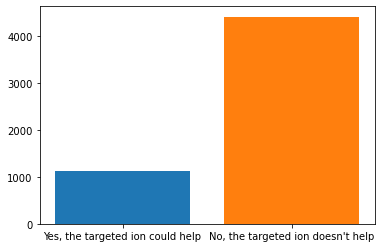

In [82]:
import matplotlib.pyplot as plt
plt.bar('Yes, the targeted ion could help', len(ms3could_help))
plt.bar('No, the targeted ion doesn\'t help', len(ms3no_help))
plt.show()